## Author
- **Meng-Hsuan (Michelle) Wu** (JHU)

## Projects
- CNN-LSTM with MSE loss

In [ ]:
import os
import os.path
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import pickle
import shutil

# Model

## Encoder

In [ ]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 2, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64,momentum=0.9),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(128, 256, kernel_size = 2, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 256, kernel_size = 2, stride = 1),
        nn.ReLU(),

        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 512, kernel_size = 3, stride = 1), 
        nn.ReLU(),
        nn.Dropout(0.2)
    )
  
  def forward(self, x):
    cnn_val = self.network(x)
    return_val = F.max_pool2d(cnn_val, kernel_size=cnn_val.size()[2:])
    return_val = torch.squeeze(return_val)
    return return_val

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.convNN = ConvNN()
    self.lstm = nn.LSTM(input_size = 512, hidden_size = 512,
                        batch_first = True, bidirectional = True,
                        num_layers = 4, dropout = 0.2)

  def forward(self, input):
    batch_size = int(input.shape[0]/img_length)
    
    in_features = self.convNN(input) 
    in_features = torch.reshape(in_features,(batch_size, img_length, 512))
    output, (h_n, c_n) = self.lstm(in_features) 
    return h_n[-1]

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, 
                               kernel_size = 4, stride = 1, padding = 0, 
                               bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid()

        )
    def forward(self, input):
      return self.main(input)

# Models

In [ ]:
class CLSTM(nn.Module):
  def __init__(self):
    super(CLSTM, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  def forward(self, x):
    y_hidden = self.encoder(x)
    y_hidden = torch.unsqueeze(y_hidden,2)
    y_hidden = torch.unsqueeze(y_hidden,3)
    y_predict = self.decoder(y_hidden)
    return y_predict

# Train

In [ ]:
def train(start_epochs,n_epochs, train_loader, val_loader, img_length,
          valid_loss_min_input, checkpoint_path,best_model_path,model,
          criterion,opt_function, train_history_lst, val_history_lst,use_cuda
          ):

  train_history = train_history_lst
  val_history = val_history_lst
  
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
  for epoch in range(start_epochs, n_epochs+1):

    ####################
    # training process #
    ####################
    model.train()
    train_loss_lst = []
    for batch_train in train_loader:

      x_train = batch_train[:,:-1,:,:,:]
      y_train = batch_train[:,-1,:,:,:]
      if use_cuda:
        x_train, y_train = x_train.cuda(), y_train.cuda()

      n_series = x_train.shape[0]
      n_img_in_series = x_train.shape[1]    
      img_channels = x_train.shape[2]
      img_height = x_train.shape[3]
      img_width = x_train.shape[4]

      x_train_new_dim = (n_series*n_img_in_series, img_channels, img_height, img_width)
      x_train = torch.reshape(x_train,x_train_new_dim)  
      
      y_train_predict = model(x_train)
      y_train_crop = fn.center_crop(y_train, output_size=[256])
      y_train_predict = fn.center_crop(y_train_predict, output_size =[256])
      train_loss = criterion(y_train_predict,y_train_crop) # train the model and calculate mse loss

      optimizer.zero_grad() 
      train_loss.backward() # backpropogation
      optimizer.step() # update the weight for the model
      train_loss_lst.append(train_loss.cpu().detach().numpy())
      
    avg_train_loss = sum(train_loss_lst)/len(train_loss_lst)
    train_history.append(avg_train_loss)

    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      tot_val_loss = 0
      val_loss_lst = []
      for batch_val in val_loader:
        x_val = batch_val[:,:-1,:,:,:]
        y_val = batch_val[:,-1,:,:,:]
        if use_cuda:
          x_val, y_val = x_val.cuda(), y_val.cuda()


        n_series_val = x_val.shape[0]
        n_img_in_series_val = x_val.shape[1]    
        img_channels_val = x_val.shape[2]
        img_height_val = x_val.shape[3]
        img_width_val = x_val.shape[4]

        x_val_new_dim = (n_series_val*n_img_in_series_val, img_channels_val, img_height_val, img_width_val)
        x_val = torch.reshape(x_val,x_val_new_dim)

        y_val_predict = model(x_val)
        y_val_crop = fn.center_crop(y_val, output_size=[256])
        y_val_predict = fn.center_crop(y_val_predict, output_size =[256])
        val_loss = criterion(y_val_predict, y_val_crop)
        val_loss_lst.append(val_loss.cpu().numpy())
      avg_val_loss = sum(val_loss_lst)/len(val_loss_lst)
      avg_val_loss_np = avg_val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, avg_train_loss,avg_val_loss))
    val_history.append(avg_val_loss_np)
    
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': avg_val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_history': train_history,
        'val_history': val_history
    }
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)

    # save the model if validation loss has decreased
    if avg_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = avg_val_loss

# Checkpoint

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
  f_path = checkpoint_path
  torch.save(state, f_path)
  if is_best:
      print("Saving a new best model")
      best_fpath = best_model_path
      shutil.copyfile(f_path, best_fpath)


In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):

    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    train_loss_lst = checkpoint['train_history']
    val_loss_lst = checkpoint['val_history']
    
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item(), train_loss_lst,val_loss_lst

# Setting Parameters

In [ ]:
# setting parameters
model = CLSTM()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
start_epochs = 0
num_epochs = 1000
batch_train_num = 16
batch_valid_num = 4
batch_test_num= 10

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.00001)
ngf = 64
nz = 100
nc = 3
img_length = 2 # how many images per series I extract
checkpoint_dir = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_checkpoint_mse_final.pt"
best_model_dir = "/content/drive/MyDrive/Capstone/Capstone_models/clstm_best_model_mse_final.pt"
valid_loss_min_input = np.Inf
train_history_lst = []
val_history_lst = []


# Loading Datapoint

In [ ]:
# convert the image to array 

x_arr = np.zeros(shape=(100,2, 3,288,432))
y_arr = np.zeros(shape=(100,1,3,288,432))


for i in range(100): # loop through 100 series
  for j in range(img_length): # loop through images within series
    model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(i)
    x_to_convert = Image.open(model_path+'/'+"{:02d}".format(j)+'im.jpg')
    x = np.asarray(x_to_convert)
    x = np.moveaxis(x,-1,0) # change image dimension to channel first
    x_arr[[i,j]] = x
  y_to_convert = Image.open(model_path+'/'+"{:02d}".format(img_length+1)+'im.jpg')
  y = np.asarray(y_to_convert)
  y = np.moveaxis(y,-1,0) # change image dimension to channel first
  y_arr[[i,0]] = y

# image dimention
n_series = x_arr.shape[0]
n_img_in_series = x_arr.shape[1]
img_channels = x_arr.shape[2]
img_height = x_arr.shape[3]
img_width = x_arr.shape[4]

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

num_train_data = X_train.shape[0]
num_val_data = X_val.shape[0]
num_test_data = X_test.shape[0]

# generating means and std for normalization
trans_X_train= torch.tensor((np.array(X_train)/255).astype(np.float32))
trans_y_train = torch.tensor((np.array(y_train)/255).astype(np.float32))
trans_X_val = torch.tensor((np.array(X_val)/255).astype(np.float32))
trans_y_val = torch.tensor((np.array(y_val)/255).astype(np.float32))
trans_X_test = torch.tensor((np.array(X_test)/255).astype(np.float32))
trans_y_test = torch.tensor((np.array(y_test)/255).astype(np.float32))


# final train/val/test data 
final_train_data = torch.cat((trans_X_train, trans_y_train), dim = 1)
final_val_data = torch.cat((trans_X_val,trans_y_val),dim = 1)
final_test_data = torch.cat((trans_X_test,trans_y_test),dim = 1)

KeyboardInterrupt: ignored

In [ ]:
train_dl = DataLoader(final_train_data, batch_train_num, shuffle = True)
val_dl = DataLoader(final_val_data, batch_valid_num, shuffle = True)
test_dl = DataLoader(final_test_data, batch_test_num, shuffle = False)


# Calling Train

In [ ]:
# fitting data to models
# train(start_epochs,num_epochs, train_dl, val_dl, img_length,
#                       valid_loss_min_input, checkpoint_dir, best_model_dir, model,
#                       criterion, optimizer, train_history_lst, val_history_lst, use_cuda)

Epoch: 1 	Training Loss: 0.131252 	Validation Loss: 0.104028
Validation loss decreased (inf --> 0.104028).  Saving model ...
Saving a new best model
Epoch: 2 	Training Loss: 0.092312 	Validation Loss: 0.102382
Validation loss decreased (0.104028 --> 0.102382).  Saving model ...
Saving a new best model
Epoch: 3 	Training Loss: 0.078926 	Validation Loss: 0.102922
Epoch: 4 	Training Loss: 0.065509 	Validation Loss: 0.104506
Epoch: 5 	Training Loss: 0.055978 	Validation Loss: 0.105142
Epoch: 6 	Training Loss: 0.051632 	Validation Loss: 0.102616
Epoch: 7 	Training Loss: 0.049366 	Validation Loss: 0.103548
Epoch: 8 	Training Loss: 0.041947 	Validation Loss: 0.103647
Epoch: 9 	Training Loss: 0.041831 	Validation Loss: 0.105287
Epoch: 10 	Training Loss: 0.037689 	Validation Loss: 0.100789
Validation loss decreased (0.102382 --> 0.100789).  Saving model ...
Saving a new best model
Epoch: 11 	Training Loss: 0.034909 	Validation Loss: 0.101133
Epoch: 12 	Training Loss: 0.033244 	Validation Loss: 

KeyboardInterrupt: ignored

In [ ]:
# loading checkpoint if model fail
ckp_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_checkpoint_mse_final.pt"
optimizer = optim.RMSprop(model.parameters(), lr = 0.00001)
model, optimizer, start_epoch, valid_loss_min, train_lst, val_lst = load_ckp(ckp_path, model, optimizer)

print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("train_lst = ",train_lst)
print("validation_lst = ",val_lst)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))


In [ ]:
# train(start_epoch,num_epochs, train_dl, val_dl, img_length,
#                       valid_loss_min, ckp_path, best_model_dir, model,
#                       criterion, optimizer, train_lst, val_lst, use_cuda)

Epoch: 420 	Training Loss: 0.013532 	Validation Loss: 0.012656
Validation loss decreased (0.013438 --> 0.012656).  Saving model ...
Saving a new best model
Epoch: 421 	Training Loss: 0.013458 	Validation Loss: 0.013503
Epoch: 422 	Training Loss: 0.013423 	Validation Loss: 0.012682
Epoch: 423 	Training Loss: 0.013453 	Validation Loss: 0.012492
Validation loss decreased (0.012656 --> 0.012492).  Saving model ...
Saving a new best model
Epoch: 424 	Training Loss: 0.013526 	Validation Loss: 0.012661
Epoch: 425 	Training Loss: 0.013403 	Validation Loss: 0.013399
Epoch: 426 	Training Loss: 0.013389 	Validation Loss: 0.010883
Validation loss decreased (0.012492 --> 0.010883).  Saving model ...
Saving a new best model
Epoch: 427 	Training Loss: 0.013411 	Validation Loss: 0.012143
Epoch: 428 	Training Loss: 0.013665 	Validation Loss: 0.011364
Epoch: 429 	Training Loss: 0.013462 	Validation Loss: 0.011939
Epoch: 430 	Training Loss: 0.013470 	Validation Loss: 0.011908
Epoch: 431 	Training Loss: 0

# Result

[0.13125237822532654, 0.09231207221746444, 0.0789259135723114, 0.06550861895084381, 0.05597819462418556, 0.05163248851895332, 0.04936649799346924, 0.04194711223244667, 0.04183050841093063, 0.037689249217510226, 0.034909489750862124, 0.033243929594755174, 0.033445452153682706, 0.03178528062999249, 0.03134752847254276, 0.02925548478960991, 0.03123481385409832, 0.02794000506401062, 0.027284896373748778, 0.027475261688232423, 0.02623932883143425, 0.025053076818585394, 0.02647539637982845, 0.025238358601927757, 0.024197889119386674, 0.02412060387432575, 0.022990240901708602, 0.02343398593366146, 0.02302222289144993, 0.02209658399224281, 0.022091927379369734, 0.022306372225284577, 0.023661785945296287, 0.02285447157919407, 0.021936850249767305, 0.021663302928209303, 0.020874298363924026, 0.021162993088364602, 0.022033649310469628, 0.020640499144792556, 0.020400622859597206, 0.01996864043176174, 0.019751985743641853, 0.020031288638710974, 0.01960381343960762, 0.019678448140621186, 0.019743616

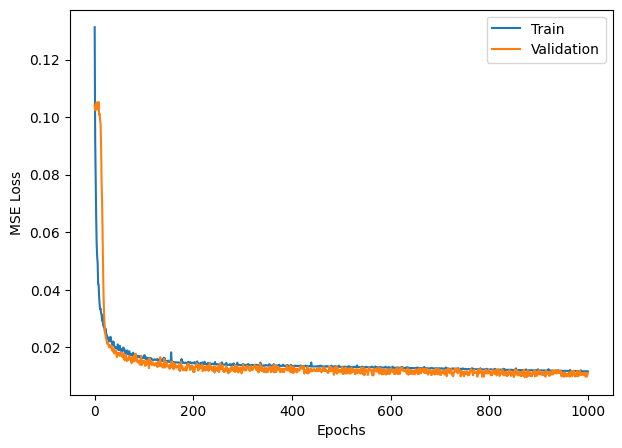

In [ ]:

new_list = []
for i in range(len(val_lst)):
  val = val_lst[i]
  new_list.append(val)
print(train_lst)
print(val_lst)
plt.subplots(figsize=(7, 5))
plt.plot(train_lst, label = "Train")
plt.plot(val_lst, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Capstone/Capstone Meeting/MSE_300_Epochs_clstm.png")
plt.show()



#Testing

In [ ]:
def test(model, test_loader, criterion):    

  model.eval()

  with torch.no_grad():
    test_loss_lst = []
    true_y_test = []
    crop_true_y = []
    pred_y_test = []
    for batch_test in test_loader:
      print(batch_test.shape)
      x_test = batch_test[:,:-1,:,:,:]
      y_test = batch_test[:,-1,:,:,:]
      if use_cuda:
        x_test, y_test = x_test.cuda(), y_test.cuda()
      n_series_test = x_test.shape[0]
      n_img_in_series_test = x_test.shape[1]    
      img_channels_test = x_test.shape[2]
      img_height_test = x_test.shape[3]
      img_width_test = x_test.shape[4]

      x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)
      x_test = torch.reshape(x_test,x_test_new_dim)

      y_test_predict = model(x_test)

      y_test_crop = fn.center_crop(y_test, output_size=[256])
      y_test_predict = fn.center_crop(y_test_predict, output_size = [256])

      real_img_out = y_test_crop*255
      pred_img_out = y_test_predict*255
      
      real_img_out = real_img_out.cpu().numpy()
      pred_img_out = pred_img_out.cpu().numpy()

      real_img_out = np.moveaxis(real_img_out,1,3)
      pred_img_out = np.moveaxis(pred_img_out, 1,3)

      real_img_out = np.uint8(real_img_out)
      pred_img_out = np.uint8(pred_img_out)
      for img_num in range(real_img_out.shape[0]):

        real_out = real_img_out[img_num]
        pred_out = pred_img_out[img_num]
      
        real_out = Image.fromarray(real_out)
        pred_out = Image.fromarray(pred_out)

        real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/mse"+'/'+"{:02d}".format(img_num)+'_real.jpg')
        pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/mse"+'/'+"{:02d}".format(img_num)+'_pred.jpg')

      test_loss = criterion(y_test_predict, y_test_crop)
      test_loss_lst.append(test_loss.cpu().numpy())
      
      y_test_true_numpy = y_test.cpu().numpy()
      crop_y_true_numpy = y_test_crop.cpu().numpy()
      y_test_pred_numpy = y_test_predict.cpu().numpy()
      
      for img_true, img_crop, img_pred in zip(y_test_true_numpy,crop_y_true_numpy,y_test_pred_numpy):
        true_y_test.append(img_true)
        crop_true_y.append(img_crop*255)
        pred_y_test.append(img_pred*255)
    avg_test_loss = sum(test_loss_lst)/len(test_loss_lst)  
  print('Average test Loss: {:.4f}'.format(avg_test_loss))
  # print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, avg_train_loss,avg_val_loss))
  return true_y_test, crop_true_y, pred_y_test

In [ ]:
def test_more(model):
  model.eval()
  with torch.no_grad():
    x_arr = np.zeros(shape=(10,2,3,288,432))
    y_arr = np.zeros(shape = (10,3,288,432))
    index = 0 
    for series in range(100,110): # loop through 100 series
      for input in range(2): # loop through images within series
        model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(series)
        x_to_convert = Image.open(model_path+'/'+"{:02d}".format(input)+'im.jpg')
        x = np.asarray(x_to_convert)
        x = np.moveaxis(x,-1,0) # change image dimension to channel first
        x_arr[index][input] = x
      y_to_convert = Image.open(model_path+'/'+"{:02d}".format(2)+'im.jpg')
      y = np.asarray(y_to_convert)
      y = np.moveaxis(y,-1,0) # change image dimension to channel first
      y_arr[index] = y
      index+=1
    x_arr = (np.array(x_arr)/255).astype(np.float32)
    y_arr = (np.array(y_arr)/255).astype(np.float32)
    x_tor = torch.tensor(x_arr)
    y_tor = torch.tensor(y_arr)
    if use_cuda:
      x_test, y_test, model = x_tor.cuda(), y_tor.cuda(), model.cuda()


    n_series_test = x_test.shape[0]
    n_img_in_series_test = x_test.shape[1]    
    img_channels_test = x_test.shape[2]
    img_height_test = x_test.shape[3]
    img_width_test = x_test.shape[4]

    x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)

    x_test = torch.reshape(x_test,x_test_new_dim)

    y_test_predict = model(x_test)
    y_test_crop = fn.center_crop(y_test, output_size=[256])
    y_test_predict = fn.center_crop(y_test_predict, output_size = [256])


    real_img_out = y_test_crop*255
    pred_img_out = y_test_predict*255
    
    real_img_out = real_img_out.cpu().numpy()
    pred_img_out = pred_img_out.cpu().numpy()

    real_img_out = np.moveaxis(real_img_out,1,3)
    pred_img_out = np.moveaxis(pred_img_out, 1,3)

    real_img_out = np.uint8(real_img_out)
    pred_img_out = np.uint8(pred_img_out)
    for img_num in range(real_img_out.shape[0]):

      real_out = real_img_out[img_num]
      pred_out = pred_img_out[img_num]
    
      real_out = Image.fromarray(real_out)
      pred_out = Image.fromarray(pred_out)

      real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/mse"+'/'+"{:02d}".format(img_num+10)+'_real.jpg')
      pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/mse"+'/'+"{:02d}".format(img_num+10)+'_pred.jpg')

    


In [ ]:
best_path = "/content/drive/MyDrive/Capstone/Capstone_models/clstm_best_model_mse_final.pt"
optimizer = optim.RMSprop(model.parameters(), lr = 0.00001)
trained_clstm_model, optimizer, start_epoch, valid_loss_min, train_lst, val_lst = load_ckp(best_path, model, optimizer)

In [ ]:
real_y_test, y_test_crop, y_test_predict = test(trained_clstm_model, test_dl,criterion)
len(y_test_predict)

torch.Size([10, 3, 3, 288, 432])
Average test Loss: 0.0112


10

In [ ]:
test_more(trained_clstm_model)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


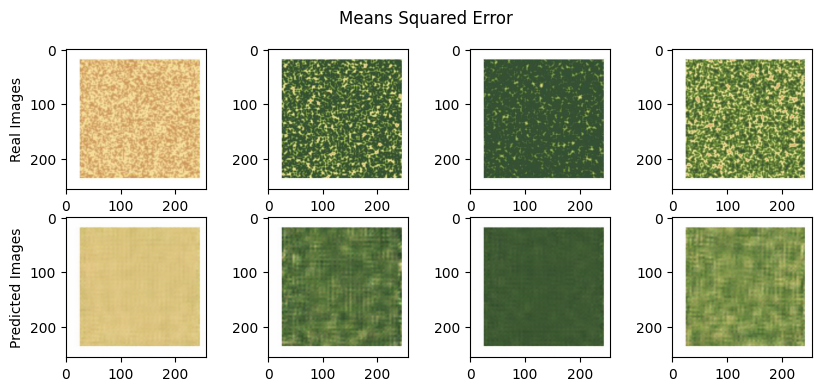

In [ ]:
f, axarr = plt.subplots(2,4,figsize=(10, 4))

img_num = 0
for img_true,img_pred in zip(y_test_crop[3:7],y_test_predict[3:7]):
  img_pred = np.moveaxis(img_pred, 0, -1)
  print(img_pred.shape)
  img_true = np.moveaxis(img_true, 0, -1)
  print(img_true.shape)

  axarr[0,img_num].imshow((img_true).astype(np.uint8))
  axarr[0,0].set_ylabel("Real Images")
  axarr[1,img_num].imshow((img_pred).astype(np.uint8))
  axarr[1,0].set_ylabel("Predicted Images")

  img_num +=1
  # plt.imshow(img_pred)
  # plt.imshow(img_crop)
f.suptitle('Means Squared Error')
plt.show()

In [ ]:
y_test_crop[7][0,14:100, 200]

array([255., 255., 245., 247., 246.,  66.,  57.,  57.,  53.,  59.,  55.,
        52.,  54.,  61.,  60.,  48.,  53.,  75.,  77.,  84.,  72., 119.,
       217., 213., 206., 172., 148., 140., 143., 145., 136., 118.,  94.,
        70.,  56.,  55.,  52.,  58.,  78.,  98.,  96.,  84.,  79.,  90.,
        89.,  73.,  60.,  49.,  44.,  47.,  50.,  55.,  57.,  50.,  49.,
        66.,  91., 110., 130., 150., 159., 136.,  96.,  78.,  84.,  87.,
       106.,  73.,  72.,  92., 139., 169., 184., 117.,  87.,  97., 119.,
       148., 165., 161., 146., 133., 132., 124.,  89.,  52.],
      dtype=float32)

In [ ]:
y_test_predict[7][0,14:100, 200]

array([254.78128 , 254.92432 , 254.96924 , 248.63487 , 249.27415 ,
       109.019516, 107.0442  , 106.34495 , 107.07733 , 106.45123 ,
       117.57658 , 108.009964, 112.78661 , 103.51154 ,  98.56846 ,
       100.23357 ,  99.08566 , 102.9282  , 113.153435, 106.239845,
       112.45811 , 105.50702 , 106.704506, 105.114716, 108.620026,
       106.90137 , 114.11491 , 110.18941 , 115.703064, 108.12961 ,
       109.62711 , 104.518166, 108.03482 , 103.69924 , 106.96143 ,
       100.26007 , 107.14824 , 101.869965, 102.59316 , 100.21409 ,
       101.47265 ,  94.31905 , 100.18634 ,  93.218155,  99.70688 ,
        96.06262 ,  99.205574,  96.053444, 100.40507 ,  96.611946,
       110.53269 , 104.08886 , 112.55812 , 104.37709 , 106.36464 ,
       103.63491 , 103.56553 , 107.144745, 111.09532 , 110.93895 ,
       116.215965, 111.141495, 113.05002 , 109.142784, 109.137215,
       114.56493 , 115.887566, 117.10851 , 119.133   , 120.49061 ,
       117.42159 , 119.01804 , 115.57006 , 116.645134, 113.859

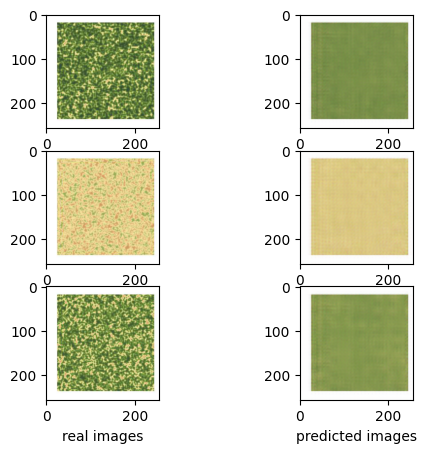

In [ ]:
ximg_len = len(y_test_crop)

f, axarr = plt.subplots(3,2,figsize=(6, 5))

img_num = 0
for img_crop,img_pred in zip(y_test_crop[:3],y_test_predict[:3]):

  # img_true = np.moveaxis(img_true, 0, -1)
  img_pred = np.moveaxis(img_pred, 0, -1)
  img_crop = np.moveaxis(img_crop, 0, -1)

  # axarr[img_num,0].imshow(img_true)
  axarr[img_num,0].imshow((img_crop).astype(np.uint8))
  
  axarr[img_num,1].imshow((img_pred).astype(np.uint8))
  axarr[2,0].set_xlabel("real images")
  axarr[2,1].set_xlabel("predicted images")
  img_num +=1
  # plt.imshow(img_pred)
  # plt.imshow(img_crop)
# plt.title("Mean Square Error Predicted Images at" )
plt.show()
# plt.save